In [8]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch

print_config()

MONAI version: 1.3.0
Numpy version: 1.25.0
Pytorch version: 2.0.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/anaconda3/envs/test_cuda_env/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.21.0
scipy version: 1.11.1
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.7.1
TorchVision version: 0.15.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about insta

In [9]:
import sys
sys.path.append("..")

from models import UNet3d, AttnUNet3d
from loss_metric import *
from dataset_dataloader import *
from trainer import Trainer

In [10]:
class GlobalConfig:
    root_dir = '/home/mandrakedrink/edu/data'
    train_root_dir = 'home/mandrakedrink/edu/brats2021'
    test_root_dir = 'home/mandrakedrink/edu/brats2021'
    path_to_train_csv = '/home/mandrakedrink/edu/dyplom_work/brats2020/unet_att/train.csv'
    path_to_test_csv = '/home/mandrakedrink/edu/dyplom_work/brats2020/unet_att/test.csv'
    pretrained_model_path = None
    train_logs_path = '/home/mandrakedrink/edu/dyplom_work/brats2020/unet_att/train_log.csv'
    seed = 55
    
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = GlobalConfig()
seed_everything(config.seed)

In [11]:
#os.listdir("/home/mandrakedrink/edu/brats2021")

In [12]:
path = os.listdir("/home/mandrakedrink/edu/brats2021")
path.remove(".DS_Store")
df = pd.DataFrame(path, columns=['Brats20ID'])
df['path'] = df['Brats20ID'].apply(lambda x : "/home/mandrakedrink/edu/brats2021/" + x )
df

,Brats20ID,path
0,BraTS2021_00194,/home/mandrakedrink/edu/brats2021/BraTS2021_00194
1,BraTS2021_00804,/home/mandrakedrink/edu/brats2021/BraTS2021_00804
2,BraTS2021_01597,/home/mandrakedrink/edu/brats2021/BraTS2021_01597
3,BraTS2021_00840,/home/mandrakedrink/edu/brats2021/BraTS2021_00840
4,BraTS2021_01133,/home/mandrakedrink/edu/brats2021/BraTS2021_01133
...,...,...
1246,BraTS2021_00744,/home/mandrakedrink/edu/brats2021/BraTS2021_00744
1247,BraTS2021_01140,/home/mandrakedrink/edu/brats2021/BraTS2021_01140
1248,BraTS2021_01080,/home/mandrakedrink/edu/brats2021/BraTS2021_01080
1249,BraTS2021_00568,/home/mandrakedrink/edu/brats2021/BraTS2021_00568


In [13]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=55)
train_df.reset_index(drop=True)
test_df.reset_index(drop=True)
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)
test_df

,Brats20ID,path
598,BraTS2021_01392,/home/mandrakedrink/edu/brats2021/BraTS2021_01392
700,BraTS2021_00263,/home/mandrakedrink/edu/brats2021/BraTS2021_00263
447,BraTS2021_00456,/home/mandrakedrink/edu/brats2021/BraTS2021_00456
164,BraTS2021_01046,/home/mandrakedrink/edu/brats2021/BraTS2021_01046
12,BraTS2021_00328,/home/mandrakedrink/edu/brats2021/BraTS2021_00328
...,...,...
134,BraTS2021_01205,/home/mandrakedrink/edu/brats2021/BraTS2021_01205
1084,BraTS2021_00324,/home/mandrakedrink/edu/brats2021/BraTS2021_00324
288,BraTS2021_01148,/home/mandrakedrink/edu/brats2021/BraTS2021_01148
315,BraTS2021_00254,/home/mandrakedrink/edu/brats2021/BraTS2021_00254


In [14]:
nodel = AttnUNet3d(in_channels=4, n_classes=3, n_channels=48).to('cuda')
def init_weights_he(m):
    if type(m) == nn.Conv3d:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    if type(m) == nn.ConvTranspose3d:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')


nodel.apply(init_weights_he);

trainer = Trainer(net=nodel,
                  dataset=BratsDataset,
                  criterion=BCEDiceLoss(),
                  lr=1e-3,
                  accumulation_steps=16,
                  batch_size=1,
                  fold=0,
                  num_epochs=2,
                  path_to_csv = config.path_to_train_csv,)

if config.pretrained_model_path is not None:
    trainer.load_predtrain_model(config.pretrained_model_path)
    
    # if need - load the logs.      
    train_logs = pd.read_csv(config.train_logs_path)
    trainer.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
    trainer.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
    trainer.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
    trainer.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
    trainer.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
    trainer.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()

device: cuda


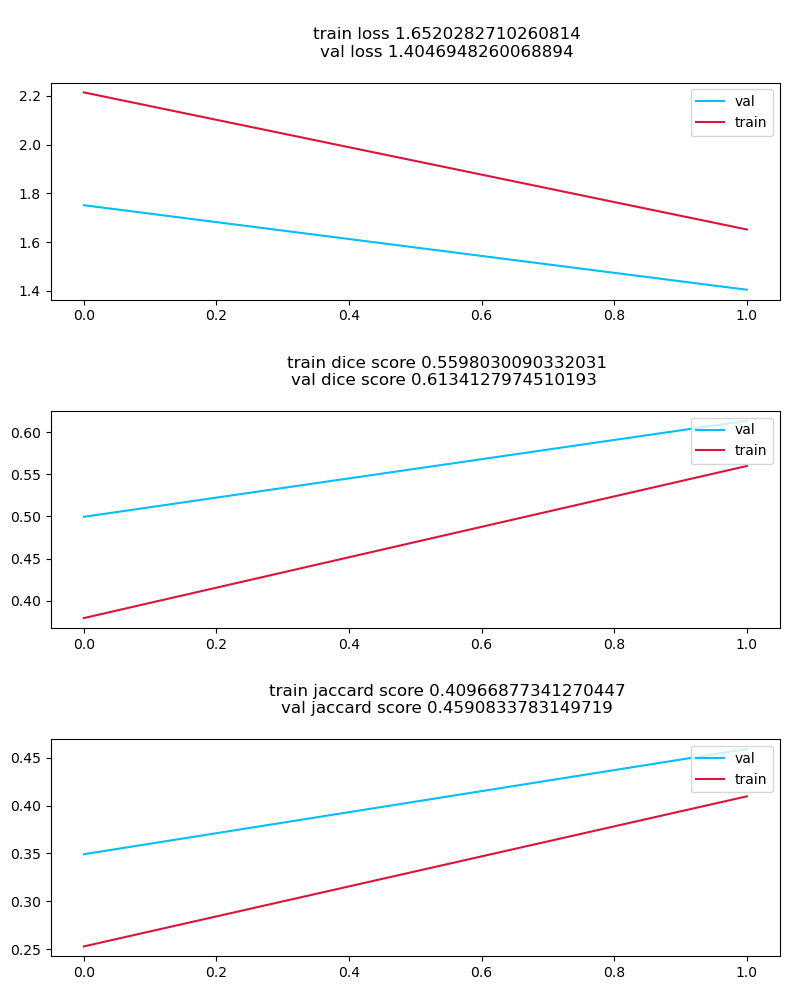


####################
Saved new checkpoint
####################




In [16]:
 trainer.run()